In [1]:
import random
import string
import re
import nltk
import torch

import copy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as dt

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from nlp_project.notebook_utils import evaluate, split
from nlp_project.nn_utils import init_gpu
from nlp_project.nn_classifier import Data, Classifier
from nlp_project.nn_extra import EarlyStopping, AdaptLR

In [2]:
seed = 69420
np.random.seed(seed)
random.seed(seed)

In [3]:
# Classification labels
labels = ["A", "B", "C", "D", "E", "F"]

# English stopwords
nltk.download("stopwords")
eng_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/riga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Import main dataset
# df = pd.read_csv("../AUTEXTIFICATION/subtask_1/train.tsv", sep="\t")
# df = df.drop("id", axis=1)

# Import main dataset
df = pd.read_csv("../../AUTEXTIFICATION/subtask_2/train.tsv", sep="\t")
df = df.drop("id", axis=1)

df

,text,label
0,It was not until many years later that it coul...,A
1,Users can then pin these images to their profi...,F
2,The best songs are those that I can sing along...,B
3,I found this book to be poorly written. It was...,D
4,Regulates the application of the EU tariff quo...,E
...,...,...
22411,The ministry had earlier said it was working w...,B
22412,"Once combined, slowly add the melted butter, s...",F
22413,Hightower for this new and wellwritten book!. ...,B
22414,All throughout the whole book this author has ...,D


In [5]:
def preprocess(df, field, remove_stop=True, vectorizer=None):
    # Convert all text to lowercase
    df[field] = df[field].apply(lambda x: x.lower())

    # Remove punctuation and reset multiple spaces to one
    punct_regex = re.compile("[" + string.punctuation + "\’'" + "]")
    whitespace_regex = re.compile(" ( )+")
    df[field] = df[field].apply(
        lambda x: whitespace_regex.sub(" ", punct_regex.sub(" ", x))
    )

    # Create dataframe without stopwords
    if remove_stop:
        df = df.copy()
        df[field] = df[field].apply(
            lambda x: " ".join([w for w in x.split() if w not in eng_stopwords])
        )
        
    x, y = df[field], df["label"]
    
    # Vectorize
    if vectorizer:
        x = vectorizer.fit_transform(x)
    
    return df, x, y

In [6]:
# min_df higher than 1 seems to perform worse
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()

In [7]:
df, x, y = preprocess(df, "text", vectorizer=vectorizer)
#dff, dff_stop = preprocess(dff, "text")

In [12]:
# train, test = train_test_split(df, test_size=0.2)
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y, test_size=0.2, val_size=0.0)

In [13]:
# Vocabulary information of main dataset
vocab = " ".join(df["text"]).split(sep=" ")

vocab_count = nltk.Counter(vocab)
vocab_count.most_common(10)

[('shall', 4508),
 ('1', 4480),
 ('2', 3990),
 ('also', 3946),
 ('article', 3938),
 ('one', 3414),
 ('regulation', 3155),
 ('said', 2889),
 ('like', 2801),
 ('use', 2714)]

In [14]:
models = []

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Naive Bayes", "model": nb_clf})

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "Linear Regression", "model": lr_clf})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({"name": "SVC", "model": svc_clf, "subsample": 0.7})

In [15]:
for model in models:
    print(f"Training {model['name']}")
    
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 1}
Best CV score: 0.3211581420233659
              precision    recall  f1-score   support

           A       0.31      0.43      0.36       712
           B       0.23      0.28      0.26       730
           C       0.25      0.25      0.25       737
           D       0.32      0.27      0.29       774
           E       0.30      0.25      0.27       765
           F       0.61      0.46      0.52       766

    accuracy                           0.32      4484
   macro avg       0.34      0.32      0.33      4484
weighted avg       0.34      0.32      0.33      4484



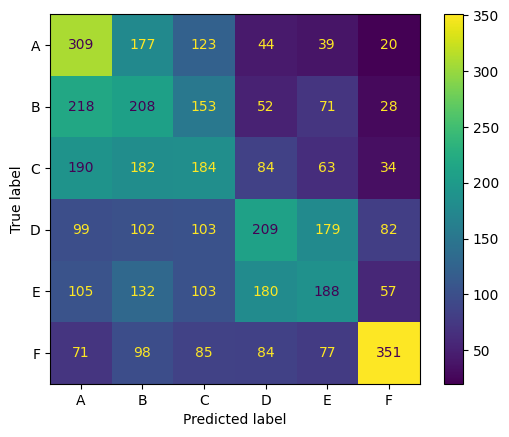

Linear Regression
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.36644003699919664
              precision    recall  f1-score   support

           A       0.43      0.45      0.44       712
           B       0.29      0.26      0.27       730
           C       0.29      0.26      0.27       737
           D       0.34      0.32      0.33       774
           E       0.30      0.28      0.29       765
           F       0.50      0.66      0.57       766

    accuracy                           0.37      4484
   macro avg       0.36      0.37      0.36      4484
weighted avg       0.36      0.37      0.36      4484



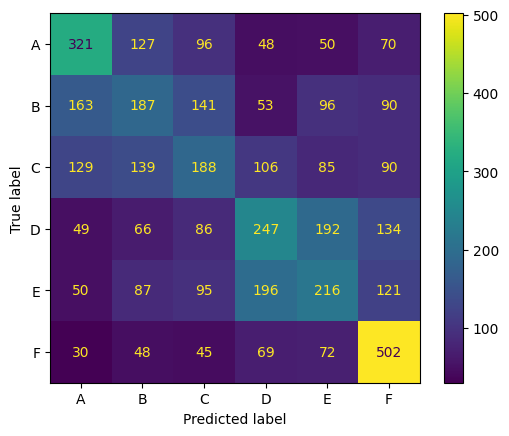

SVC
Best parameters: {'C': 1, 'kernel': 'rbf'}
Best CV score: 0.33779476095789746
              precision    recall  f1-score   support

           A       0.45      0.44      0.45       712
           B       0.32      0.32      0.32       730
           C       0.33      0.29      0.31       737
           D       0.39      0.40      0.39       774
           E       0.33      0.27      0.29       765
           F       0.49      0.64      0.56       766

    accuracy                           0.39      4484
   macro avg       0.39      0.39      0.39      4484
weighted avg       0.39      0.39      0.39      4484



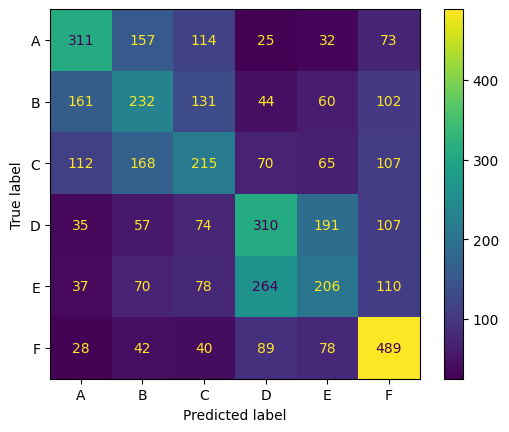

In [16]:
for model in models:
    print(f"{model['name']}")
    print(f"Best parameters: {model['model'].best_params_}")
    print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [18]:
in_dim = x.shape[1]
out_dim = 1 if len(labels) <= 2 else len(labels)

epochs = 100
batch_size = 32

num_workers = 8 # Tune it based on your machine specs
device = init_gpu()

In [19]:
class Network(Classifier):
    def __init__(self, in_dim, out_dim, binary_classifier=False, device=torch.device("cpu"), verbose=True):
        super().__init__(binary_classifier, device, verbose)
        self.l1 = nn.Linear(in_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, out_dim)
        self.dp = nn.Dropout(p=0.5)
        
        self.relu = nn.ReLU()
        self.sm = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dp(x)
        x = self.sm(self.l3(x))
        return x

In [20]:
y_ = LabelEncoder().fit_transform(y).astype(float)
x_train, x_val, x_test, y_train, y_val, y_test = split(x, y_, test_size=0.1, val_size=0.1)
ds_train = Data(x_train, y_train, y_type=torch.long)
ds_val = Data(x_val, y_val, y_type=torch.long)
ds_test = Data(x_test, y_test, y_type=torch.long)

train_dl = dt.DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
val_dl = dt.DataLoader(ds_val,     
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
test_dl = dt.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [23]:
nn_model = Network(in_dim, out_dim, binary_classifier=False, device=device)
loss = nn.CrossEntropyLoss()
optimizer = opt.Adam(nn_model.parameters(), lr=0.001)
nn_model.compile(loss, optimizer)

In [24]:
earlystop = EarlyStopping(metric="val_acc", patience=10, baseline=0.3)
lradjust = AdaptLR(metric="val_acc", patience=5, factor=0.1)
callbacks = [earlystop, lradjust]
history = nn_model.train_loop(train_dl, epochs, data_val=val_dl, callbacks=callbacks)

Epoch 1 -- loss: 0.0550805 acc: 0.3031452 val_loss: 0.0553913 val_acc: 0.3189117
Epoch 2 -- loss: 0.0535799 acc: 0.4222619 val_loss: 0.0552721 val_acc: 0.3064228
Epoch 3 -- loss: 0.0526551 acc: 0.4797011 val_loss: 0.0552669 val_acc: 0.3086530
Epoch 4 -- loss: 0.0522341 acc: 0.5173433 val_loss: 0.0553031 val_acc: 0.3287244
Epoch 5 -- loss: 0.0520933 acc: 0.5402632 val_loss: 0.0553172 val_acc: 0.3202498
Epoch 6 -- loss: 0.0519719 acc: 0.5670310 val_loss: 0.0554733 val_acc: 0.3260482
Epoch 7 -- loss: 0.0519072 acc: 0.5838166 val_loss: 0.0553548 val_acc: 0.3251561
Epoch 8 -- loss: 0.0518439 acc: 0.5988735 val_loss: 0.0554180 val_acc: 0.3113292
Reducing lr to 0.0001
Epoch 9 -- loss: 0.0518072 acc: 0.6083538 val_loss: 0.0554635 val_acc: 0.3247101
Epoch 10 -- loss: 0.0517963 acc: 0.6210127 val_loss: 0.0555164 val_acc: 0.3273863
Epoch 11 -- loss: 0.0518091 acc: 0.6178340 val_loss: 0.0554386 val_acc: 0.3175736
Epoch 12 -- loss: 0.0517825 acc: 0.6307718 val_loss: 0.0553688 val_acc: 0.3229260
Epo

{'acc': tensor(0.3216), 'loss': 0.05553154786924078}
              precision    recall  f1-score   support

         0.0       0.41      0.38      0.39       356
         1.0       0.23      0.27      0.25       365
         2.0       0.24      0.27      0.26       368
         3.0       0.31      0.30      0.30       387
         4.0       0.26      0.28      0.27       383
         5.0       0.56      0.43      0.49       383

    accuracy                           0.32      2242
   macro avg       0.34      0.32      0.33      2242
weighted avg       0.34      0.32      0.33      2242



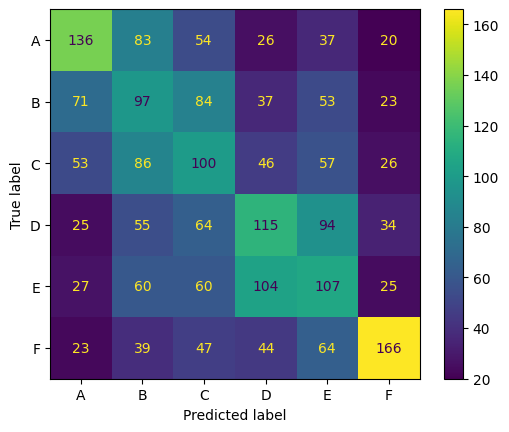

In [25]:
y_pred, metrics = nn_model.test_loop(test_dl)
print(metrics)
evaluate(y_test, y_pred, labels=labels)

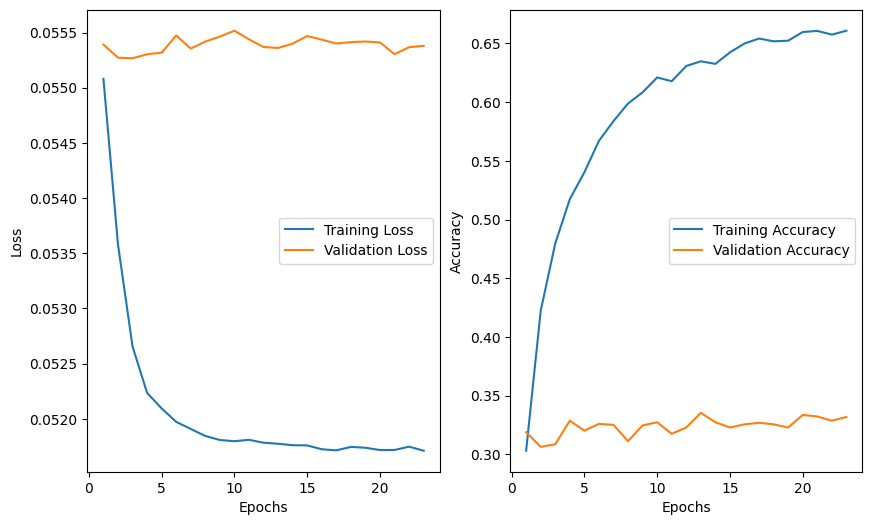

In [26]:
history = nn_model.history
plt_epochs = [h["epoch"] for h in history]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

tl = ax1.plot(plt_epochs, [h["loss"] for h in history], label="Training Loss")
vl = ax1.plot(plt_epochs, [h["val_loss"] for h in history], label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ta = ax2.plot(plt_epochs, [h["acc"] for h in history], label="Training Accuracy")
va = ax2.plot(plt_epochs, [h["val_acc"] for h in history], label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()